# **Time Series Modeling with Prophet**

# Importing Dependencies

In [1]:
! pip install -q pystan 

In [10]:
# general processing
import numpy as np 
import pandas as pd 

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns 

# metric evaluation
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from sklearn.linear_model import LinearRegression

# prophet 
from prophet import Prophet

# Load the dataset

In [11]:
df = pd.read_csv('/kaggle/input/time-series-starter-dataset/Month_Value_1.csv')
df.head()

,Period,Revenue,Sales_quantity,Average_cost,The_average_annual_payroll_of_the_region
0,01.01.2015,1.601007e+07,12729.0,1257.763541,30024676.0
1,01.02.2015,1.580759e+07,11636.0,1358.507000,30024676.0
2,01.03.2015,2.204715e+07,15922.0,1384.697024,30024676.0
3,01.04.2015,1.881458e+07,15227.0,1235.606705,30024676.0
4,01.05.2015,1.402148e+07,8620.0,1626.621765,30024676.0


# Exploring the dataset

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 5 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Period                                    96 non-null     object 
 1   Revenue                                   64 non-null     float64
 2   Sales_quantity                            64 non-null     float64
 3   Average_cost                              64 non-null     float64
 4   The_average_annual_payroll_of_the_region  64 non-null     float64
dtypes: float64(4), object(1)
memory usage: 3.9+ KB


We see that there are some null values present for the attributes - 'Revenue', 'Sales Quantity' , 'Average Cost' , 'Average payroll of the region'. We can also look at the null values graphically. 

In [13]:
df.isna().sum()

Period                                       0
Revenue                                     32
Sales_quantity                              32
Average_cost                                32
The_average_annual_payroll_of_the_region    32
dtype: int64

<Axes: >

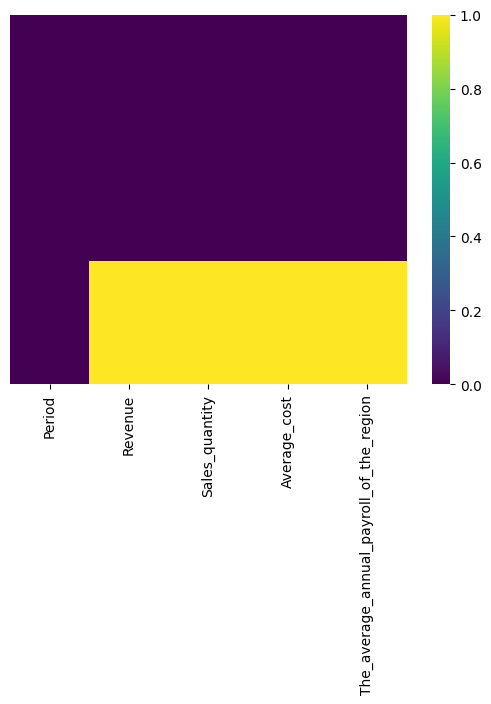

In [14]:
sns.heatmap(df.isnull(), yticklabels= False, cbar=True, cmap='viridis')

Looking at the df, we find that the first 64 rows are the actual data and the next 36 rows are the dummy data for which we need to predict. We can drop these rows for the time being to process things easily and then generate the dummy dates using prophet's "make_future_dataframe" function.

In [15]:
pd.set_option('display.max_rows', None)
df.head(100)

,Period,Revenue,Sales_quantity,Average_cost,The_average_annual_payroll_of_the_region
0,01.01.2015,1.601007e+07,12729.0,1257.763541,30024676.0
1,01.02.2015,1.580759e+07,11636.0,1358.507000,30024676.0
2,01.03.2015,2.204715e+07,15922.0,1384.697024,30024676.0
3,01.04.2015,1.881458e+07,15227.0,1235.606705,30024676.0
4,01.05.2015,1.402148e+07,8620.0,1626.621765,30024676.0
5,01.06.2015,1.678393e+07,13160.0,1275.374508,30024676.0
6,01.07.2015,1.916189e+07,17254.0,1110.576805,30024676.0
7,01.08.2015,1.520498e+07,8642.0,1759.428870,30024676.0
8,01.09.2015,2.060394e+07,16144.0,1276.259909,30024676.0
9,01.10.2015,2.099287e+07,18135.0,1157.588904,30024676.0


In [16]:
df.dropna(inplace = True)

In [17]:
df.head(64)

,Period,Revenue,Sales_quantity,Average_cost,The_average_annual_payroll_of_the_region
0,01.01.2015,1.601007e+07,12729.0,1257.763541,30024676.0
1,01.02.2015,1.580759e+07,11636.0,1358.507000,30024676.0
2,01.03.2015,2.204715e+07,15922.0,1384.697024,30024676.0
3,01.04.2015,1.881458e+07,15227.0,1235.606705,30024676.0
4,01.05.2015,1.402148e+07,8620.0,1626.621765,30024676.0
5,01.06.2015,1.678393e+07,13160.0,1275.374508,30024676.0
6,01.07.2015,1.916189e+07,17254.0,1110.576805,30024676.0
7,01.08.2015,1.520498e+07,8642.0,1759.428870,30024676.0
8,01.09.2015,2.060394e+07,16144.0,1276.259909,30024676.0
9,01.10.2015,2.099287e+07,18135.0,1157.588904,30024676.0


In [18]:
type(df['Period'][0])

str

We see that the type of the column Period is string, but we need the dates in the timestamp format, for prophet to run properly. 

In [19]:
df['Period'] = pd.to_datetime(df['Period'], format='%d.%m.%Y')

In [20]:
type(df['Period'][0])

pandas._libs.tslibs.timestamps.Timestamp

In [21]:
df.tail(1)

,Period,Revenue,Sales_quantity,Average_cost,The_average_annual_payroll_of_the_region
63,2020-04-01,5.232069e+07,26615.0,1965.83479,29044998.0


## Finding the macro trend of Sales by using Regression for the given time periods.

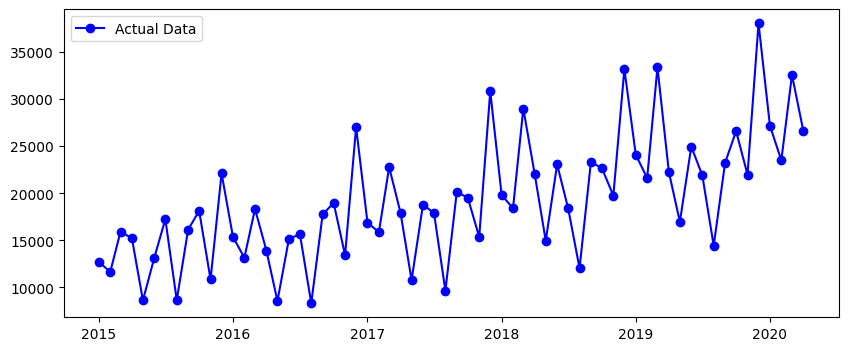

In [22]:
plt.figure(figsize=(10, 4))
plt.plot(df['Period'], df['Sales_quantity'], marker='o', label='Actual Data', color='b', linestyle='-')
plt.legend()

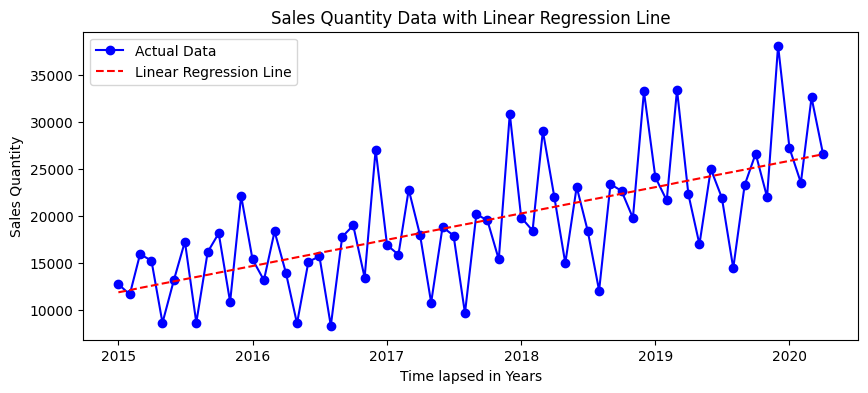

In [23]:
# Linear Regression 
model = LinearRegression()
X = np.arange(len(df)).reshape(-1, 1)
y = df['Sales_quantity']
model.fit(X, y)

# Plot the linear regression line
y_pred = model.predict(X)

plt.figure(figsize=(10, 4))
plt.plot(df['Period'], df['Sales_quantity'], marker='o', label='Actual Data', color='b', linestyle='-')
plt.plot(df['Period'], y_pred, label='Linear Regression Line', color='r', linestyle='--')

plt.xlabel('Time lapsed in Years')
plt.ylabel('Sales Quantity')
plt.title('Sales Quantity Data with Linear Regression Line')
plt.legend()

As evident from the graph above, the overall sales has increased from 2015 to 2020,and also we can see that there are recurring crests and peaks for certain months every year, indicating high seasonality in the sales figure. 

We will do the same for revenue as well and see the macro trend which emerges.

## Finding the macro trend of Revenue by using Regression for the given time periods.

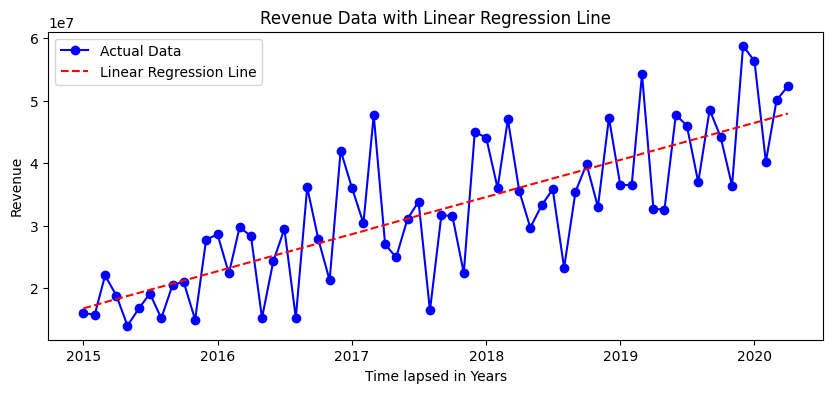

In [24]:
model = LinearRegression()
X = np.arange(len(df)).reshape(-1, 1)
y = df['Revenue']
model.fit(X, y)


# Plotting the regression line
y_pred = model.predict(X)

plt.figure(figsize=(10, 4))
plt.plot(df['Period'], df['Revenue'], marker='o', label='Actual Data', color='b', linestyle='-')
plt.plot(df['Period'], y_pred, label='Linear Regression Line', color='r', linestyle='--')

plt.xlabel('Time lapsed in Years')
plt.ylabel('Revenue')
plt.title('Revenue Data with Linear Regression Line')
plt.legend()

Upward trend emerges for revenue as well.

# Preparing dataframe for Prophet's use

In [25]:
df.head()

,Period,Revenue,Sales_quantity,Average_cost,The_average_annual_payroll_of_the_region
0,2015-01-01,1.601007e+07,12729.0,1257.763541,30024676.0
1,2015-02-01,1.580759e+07,11636.0,1358.507000,30024676.0
2,2015-03-01,2.204715e+07,15922.0,1384.697024,30024676.0
3,2015-04-01,1.881458e+07,15227.0,1235.606705,30024676.0
4,2015-05-01,1.402148e+07,8620.0,1626.621765,30024676.0


We will take a subset of our df and make another dataframe (say - 'data') which will be used for modeling

In [26]:
data = df[['Period', 'Sales_quantity']]
data = data.rename(columns={'Period': 'ds', 'Sales_quantity': 'y'})

In [27]:
data.head()

,ds,y
0,2015-01-01,12729.0
1,2015-02-01,11636.0
2,2015-03-01,15922.0
3,2015-04-01,15227.0
4,2015-05-01,8620.0


In [28]:
model = Prophet()

In [29]:
model.fit(data)

06:25:29 - cmdstanpy - INFO - Chain [1] start processing
06:25:29 - cmdstanpy - INFO - Chain [1] done processing


# Creating dummy data to test our model

In [30]:
# we have data ranging from Jan 2015 to April 2020 in our training set. We add 32 months to get to Dec 2022 
# which was initially in our dataset, before we dropped it

future = model.make_future_dataframe(periods=33, freq='m') # periods is 32+1, last one is python for loop types, not inclusive. 

In [31]:
future.tail()

,ds
92,2022-08-31
93,2022-09-30
94,2022-10-31
95,2022-11-30
96,2022-12-31


# Predicting the future sales projections

In [32]:
forecast = model.predict(future)

In [33]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01,12234.539082,11365.156590,14963.037643,12234.539082,12234.539082,897.947728,897.947728,897.947728,897.947728,897.947728,897.947728,0.0,0.0,0.0,13132.486810
1,2015-02-01,12431.329261,9361.508715,12876.017709,12431.329261,12431.329261,-1438.899716,-1438.899716,-1438.899716,-1438.899716,-1438.899716,-1438.899716,0.0,0.0,0.0,10992.429545
2,2015-03-01,12609.075229,17883.518724,21367.160396,12609.075229,12609.075229,6970.338328,6970.338328,6970.338328,6970.338328,6970.338328,6970.338328,0.0,0.0,0.0,19579.413557
3,2015-04-01,12805.865408,11542.038823,15245.606608,12805.865408,12805.865408,560.035181,560.035181,560.035181,560.035181,560.035181,560.035181,0.0,0.0,0.0,13365.900589
4,2015-05-01,12996.307516,5298.079393,8923.830205,12996.307516,12996.307516,-5947.461049,-5947.461049,-5947.461049,-5947.461049,-5947.461049,-5947.461049,0.0,0.0,0.0,7048.846466


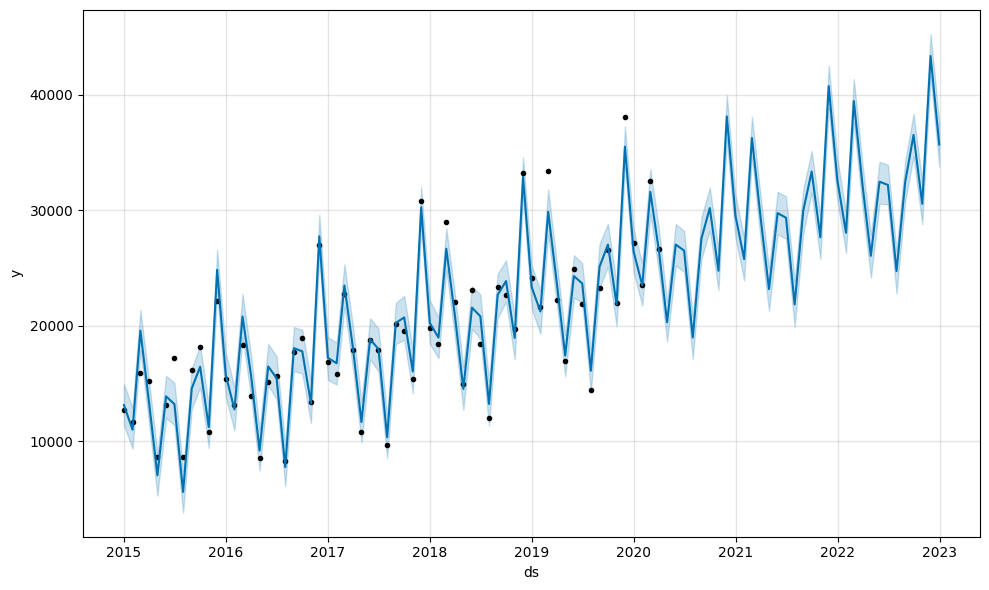

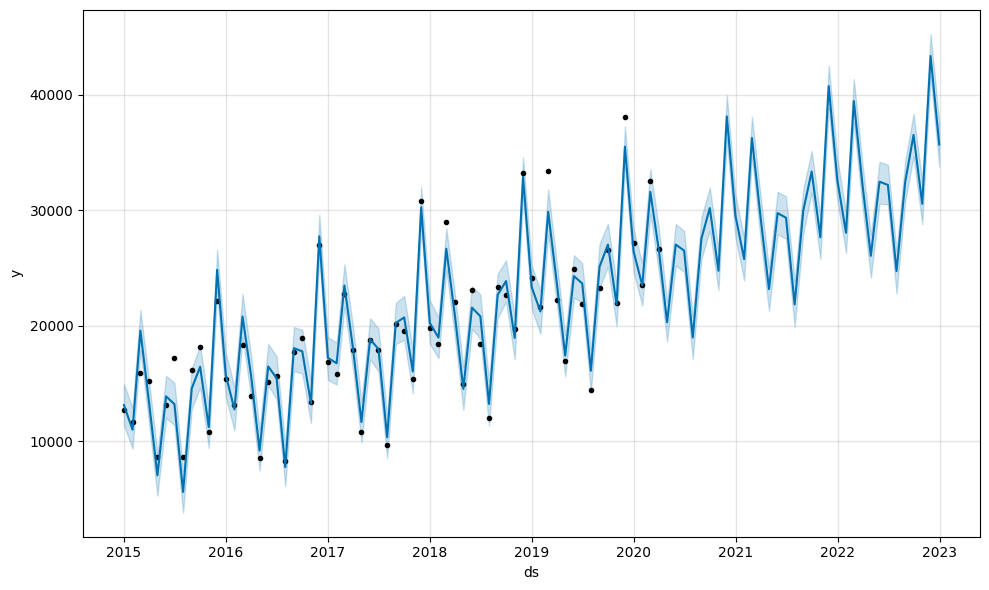

In [34]:
model.plot(forecast)

# Visualization

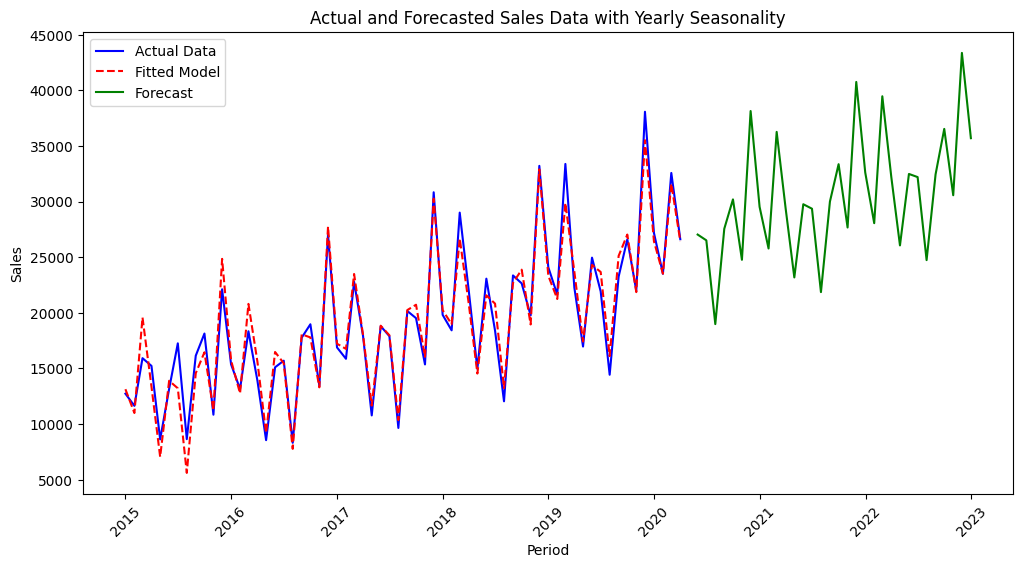

In [35]:
# Plot the actual data 
plt.figure(figsize=(12, 6))
plt.plot(data['ds'], data['y'], label='Actual Data', color='b', linestyle='-')

# Plot the fitted line
plt.plot(data['ds'], forecast['yhat'][:64], label='Fitted Model', color='r', linestyle='--')

# Plot the forecasted data 
plt.plot(forecast['ds'].tail(32), forecast['yhat'].tail(32), label='Forecast', color='g', linestyle='-')


plt.xlabel('Period')
plt.ylabel('Sales')
plt.title('Actual and Forecasted Sales Data with Yearly Seasonality')
plt.xticks(rotation=45)

plt.legend()
plt.show()

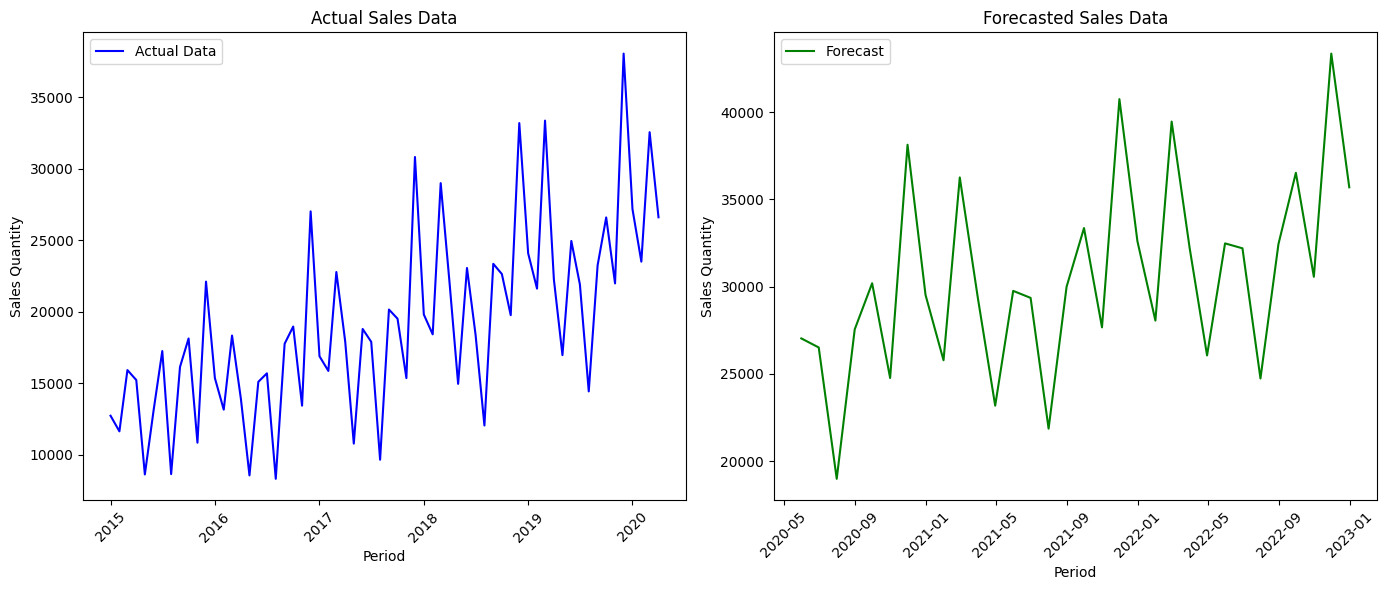

In [36]:
# Plot the actual data
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.lineplot(x='ds', y='y', data=data, label='Actual Data', color='b')
plt.title('Actual Sales Data')
plt.xlabel('Period')
plt.ylabel('Sales Quantity')
plt.xticks(rotation=45)
plt.legend()

# Plot the forecasted data
plt.subplot(1, 2, 2)
sns.lineplot(x='ds', y='yhat', data=forecast.tail(32), label='Forecast', color='g')
plt.title('Forecasted Sales Data')
plt.xlabel('Period')
plt.ylabel('Sales Quantity')
plt.xticks(rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

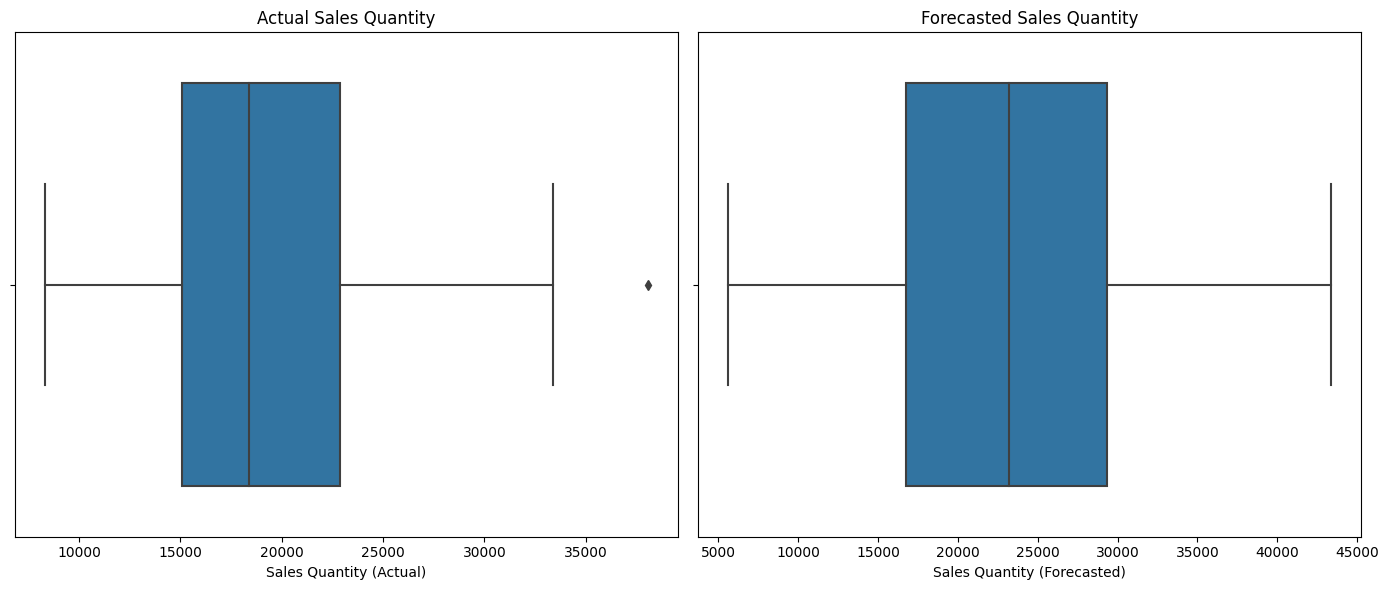

In [37]:
# Box plot of actual sales
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.boxplot(x=data['y'])
plt.title('Actual Sales Quantity')
plt.xlabel('Sales Quantity (Actual)')

# Box plot of forecasted sales
plt.subplot(1, 2, 2)
sns.boxplot(x=forecast['yhat'])
plt.title('Forecasted Sales Quantity')
plt.xlabel('Sales Quantity (Forecasted)')

plt.tight_layout()
plt.show()

As evident from the graphs above that there is to be a likely increase in the sales figure in the coming 2 years.

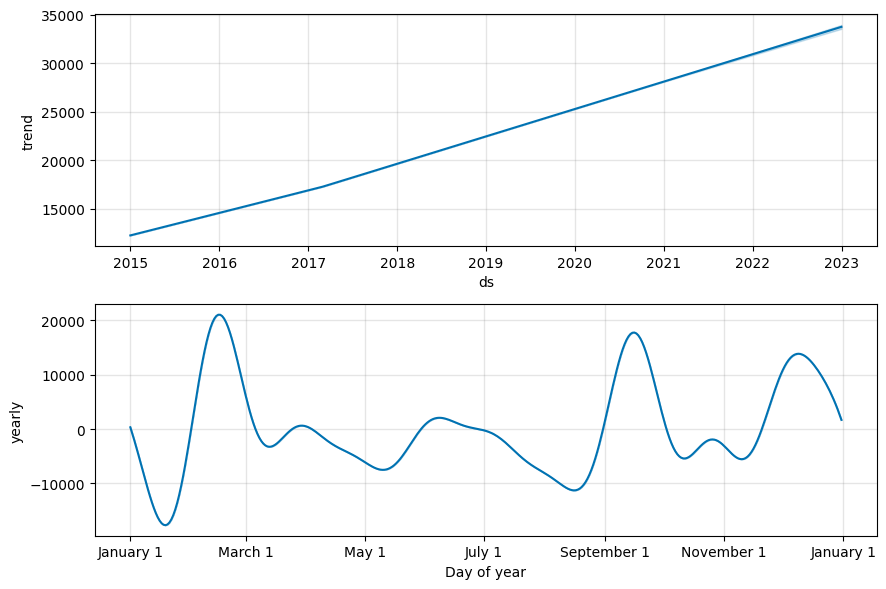

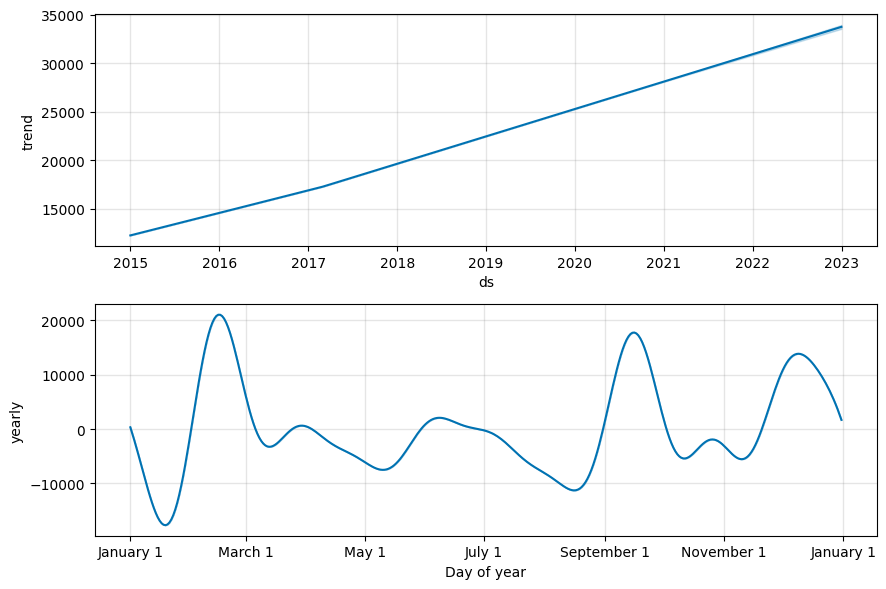

In [38]:
model.plot_components(forecast)

Some glitch - graphs occuring twice (ignore please)


Inference - There is a psoitive trend which we can find for the sales figure. Also we can see that during the months of Feb-March & Sep-Oct, we see a bloom in the sales, where as for the months March to September, the business runs a little cold.  

# Metric Evaluation

In [47]:
df_cv = cross_validation(model, initial='1095 days', period='180 days', horizon = '365 days')
df_cv.head()

  0%|          | 0/3 [00:00<?, ?it/s]

06:38:36 - cmdstanpy - INFO - Chain [1] start processing
06:38:36 - cmdstanpy - INFO - Chain [1] done processing
06:38:36 - cmdstanpy - INFO - Chain [1] start processing
06:38:37 - cmdstanpy - INFO - Chain [1] done processing
06:38:37 - cmdstanpy - INFO - Chain [1] start processing
06:38:38 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2018-05-01,14522.908122,13185.573052,15899.689009,14959.0,2018-04-07
1,2018-06-01,20330.457777,18871.986588,21742.422971,23067.0,2018-04-07
2,2018-07-01,22560.402542,21117.389047,23815.041406,18397.0,2018-04-07
3,2018-08-01,14414.205760,12944.679086,15756.746330,12045.0,2018-04-07
4,2018-09-01,23247.848237,21839.516481,24571.358123,23358.0,2018-04-07


In [48]:
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,29 days,1.290477e+06,1135.991449,928.496363,0.050719,0.029230,0.052260,0.666667
1,55 days,3.723306e+06,1929.586910,1695.313145,0.080546,0.093775,0.084437,0.333333
2,58 days,4.546072e+06,2132.152042,1887.405350,0.073678,0.073169,0.076957,0.333333
3,60 days,5.261945e+06,2293.892914,2237.797417,0.084598,0.073169,0.088678,0.333333
4,85 days,8.543697e+06,2922.960342,2713.417523,0.120489,0.073169,0.114408,0.333333


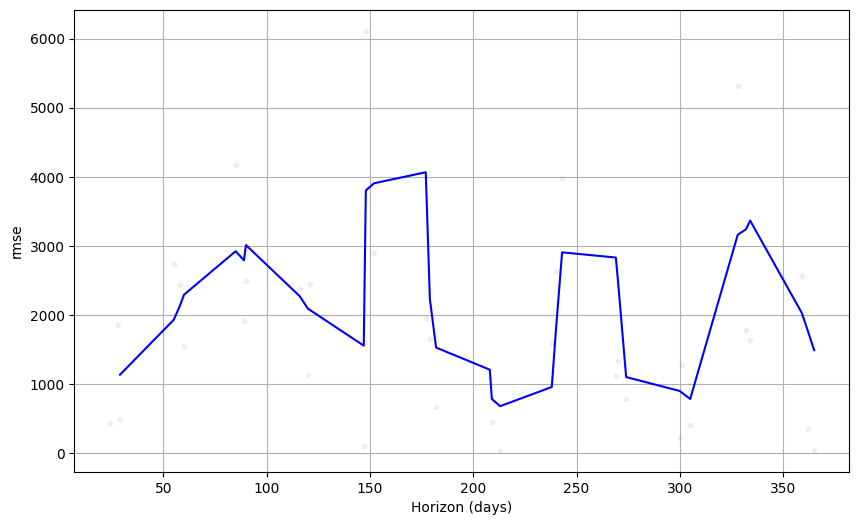

In [49]:
fig = plot_cross_validation_metric(df_cv, metric='rmse')

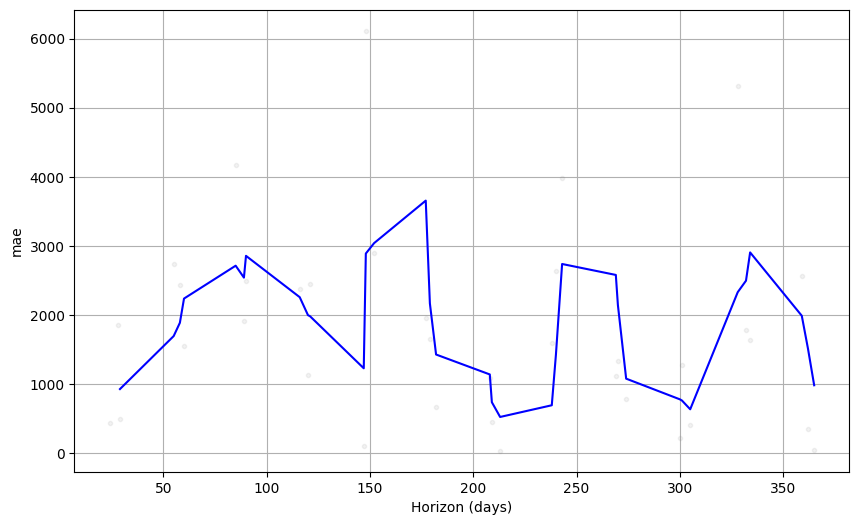

In [50]:
fig = plot_cross_validation_metric(df_cv, metric='mae')